### 0.Lib
#### ref: https://pypi.org/project/pandasql/

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
#import seaborn as sns; sns.set()

#------------------------------
#-- Read in Asset_Daily_View --
#------------------------------

df = pd.read_csv('BTC.csv')

#--------------------
#-- Pre-Processing --
#--------------------
# need to convert text to date
# ref code: raw_data['Mycol'] = pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')

df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
df['year'] = pd.DatetimeIndex(df['Date']).year # https://erikrood.com/Python_References/extract_month_year_pandas_final.html
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
#df['month_year'] = pd.to_datetime(df['Date']).dt.to_period('M') # still object
#df['YMD'] = pd.to_datetime(df['Date']).dt.to_period('D') # still object
df = df.set_index('Date') # need to have df = in the front... do I have to sort it?
df.sort_index(inplace=True)
df.head()

,Open,High,Low,Close,Volume,Market Cap,year,month,day
Date,,,,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,-,1500519936,2013,4,28
2013-04-29,134.44,147.49,134.00,144.54,-,1491160064,2013,4,29
2013-04-30,144.00,146.93,134.05,139.00,-,1597779968,2013,4,30
2013-05-01,139.00,139.89,107.72,116.99,-,1542819968,2013,5,1
2013-05-02,116.38,125.60,92.28,105.21,-,1292189952,2013,5,2


### 1. Strategy File
#### - add pos_chg col (position change)
#### - subset to 2018+

In [2]:
q = """SELECT 
      df.*
     ,year*10000+month*100+day as YMD
     ,case 
        when Date = '2018-01-01 00:00:00.000000' then 1 else 0 
      end as pos_chg
    FROM
      df
    WHERE
      Date >= '2018-01-01 00:00:00.000000'
    ;"""
df = pysqldf(q)
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap,year,month,day,YMD,pos_chg
0,2018-01-01 00:00:00.000000,14112.2,14112.2,13154.7,13657.2,10291200000,236724797440,2018,1,1,20180101,1
1,2018-01-02 00:00:00.000000,13625.0,15444.6,13163.6,14982.1,16846600192,228578836480,2018,1,2,20180102,0
2,2018-01-03 00:00:00.000000,14978.2,15572.8,14844.5,15201.0,16871900160,251311702016,2018,1,3,20180103,0
3,2018-01-04 00:00:00.000000,15270.7,15739.7,14522.2,15599.2,21783199744,256250429440,2018,1,4,20180104,0
4,2018-01-05 00:00:00.000000,15477.2,17705.2,15202.8,17429.5,23840899072,259747708928,2018,1,5,20180105,0


### 2. Return File
#### - calculate return

In [3]:
## market value
df['cum_pos'] = df['pos_chg'].cumsum()
df['market_value'] = df['cum_pos']*df['Close']

## cost
df['cost'] = df['pos_chg']*df['Close']
df['cum_cost'] = df['cost'].cumsum()

## return of 1
df['pct_return1'] = df['market_value']/df['cum_cost']
df.head()

,Date,Open,High,Low,Close,Volume,Market Cap,year,month,day,YMD,pos_chg,cum_pos,market_value,cost,cum_cost,pct_return1
0,2018-01-01 00:00:00.000000,14112.2,14112.2,13154.7,13657.2,10291200000,236724797440,2018,1,1,20180101,1,1,13657.2,13657.2,13657.2,1.000000
1,2018-01-02 00:00:00.000000,13625.0,15444.6,13163.6,14982.1,16846600192,228578836480,2018,1,2,20180102,0,1,14982.1,0.0,13657.2,1.097011
2,2018-01-03 00:00:00.000000,14978.2,15572.8,14844.5,15201.0,16871900160,251311702016,2018,1,3,20180103,0,1,15201.0,0.0,13657.2,1.113039
3,2018-01-04 00:00:00.000000,15270.7,15739.7,14522.2,15599.2,21783199744,256250429440,2018,1,4,20180104,0,1,15599.2,0.0,13657.2,1.142196
4,2018-01-05 00:00:00.000000,15477.2,17705.2,15202.8,17429.5,23840899072,259747708928,2018,1,5,20180105,0,1,17429.5,0.0,13657.2,1.276213


### 3. Visualization
#### ref re ticks https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html

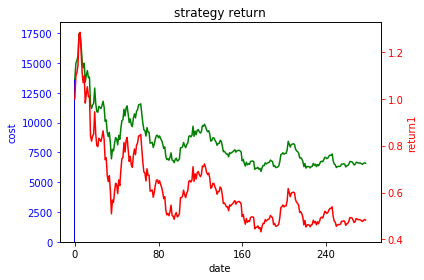

In [8]:
import matplotlib.dates as mdates

x1 = df.index.values
y1 = df['cost']
y2 = df['Close']
y3 = df['pct_return1']

fig, ax1 = plt.subplots()
    
ax1.bar(x1, y1, color='b') # cost
ax1.plot(x1, y2, color='g') # price
ax1.set_xlabel('date')

### Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('cost', color='b')
ax1.tick_params('y', colors='b')

### Twin axis
ax2 = ax1.twinx()
ax2.plot(x1, y3, color='r')
ax2.set_ylabel('return1', color='r')
ax2.tick_params('y', colors='r')

plt.title('strategy return')
plt.xticks(x1)

### set max n ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
plt.show()

In [ ]:
### ref code from https://ec2-18-216-100-196.us-east-2.compute.amazonaws.com:8888/notebooks/XGB%20-%20Model%20Dev%20Data%20Bivariant.ipynb
for x1 in X.columns[0:5]:
    print(x1)
    
    ### bin by x1
    df = my_decile(df, target='price', binvar=x1, weight='weight', num_bin=10, eqsize=False)
    
    ### create summary
    var = df.groupby('bin').agg({"weight": np.sum, "price": np.sum})
    var['avg_price'] = var['price'] / var['weight']
    print(var)
    
    ### plot
    x=var.index.values
    y1=var['weight']
    y2=var['avg_price']

    fig, ax1 = plt.subplots()
    
    ax1.bar(x, y1, color='b')
    ax1.set_xlabel('bins')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('weight', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(x, y2, color='r')
    ax2.set_ylabel('avg target', color='r')
    ax2.tick_params('y', colors='r')
    
    plt.title(x1)
    plt.xticks(x)
    
    plt.tight_layout()
    plt.show()

In [27]:
### test datetime compare
dt1 = datetime(2018,1,3)
dt2 = datetime(2018,1,2)
dt1 > dt2

True

### Try pandasSQL

In [10]:
q = """SELECT
      date
     ,case
        when Close >= 120 then 1
        else 0
      end as close_gt120_ind
     ,Close
    FROM
      df
    ;"""
df2 = pysqldf(q)
df2.head()

,Date,close_gt120_ind,Close
0,2013-04-28 00:00:00.000000,1,134.21
1,2013-04-29 00:00:00.000000,1,144.54
2,2013-04-30 00:00:00.000000,1,139.00
3,2013-05-01 00:00:00.000000,0,116.99
4,2013-05-02 00:00:00.000000,0,105.21
